# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
The model which you will be coding in this HW very similar to the Speller module from HW4P2.

# Get modules and datasets

In [1]:
!pip install torchsummaryX==1.1.0
!pip install wandb --quiet
!pip install matplotlib
!pip install seaborn

!pip install transformers -U
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1


In [2]:
# # TODO: Import drive if you are using Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import sys
path = '/kaggle/input/hw4-p1/dataset' # TODO: Add path to handout. For example ~/IDL/hw4/hw4p1_handout
sys.path.append(path)
%cd {path}

/kaggle/input/hw4-p1/dataset


# Imports

In [4]:
%matplotlib inline

import torch

import os

import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torchsummaryX
import torch.nn as nn
import torch.nn.functional as F
import math
import gc
import glob
import wandb
import yaml
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import get_linear_schedule_with_warmup

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda


# Config

In [5]:
config = {
    "token_type":  "1k",           # Options: "char", "1k", "10k"
    "d_model":     256,               # Embedding dimension
    "num_layers":  4,                 # Number of Transformer blocks
    "num_heads":   4,                 # Number of attention heads
    "d_ff":        512,              # Dimension of feed-forward network
    "dropout":     0.1,               # Dropout rate
    "max_length":  50,               # Maximum sequence length
    "lr":          1e-3,              # Learning rate
    "batch_size":  64,                # Batch size
    "num_epochs":  50,                # Number of training epochs
}

# Load datasets

In [6]:
# Define the vocabulary. Try printing and see
VOCAB = [
   "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ", "<pad>"
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}
# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
PAD_TOKEN =  VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

df_train = pd.read_csv("/kaggle/input/hw4-p1/dataset/train-clean-100/transcripts.csv")
df_val = pd.read_csv("/kaggle/input/hw4-p1/dataset/dev-clean/transcripts.csv")

df_train.head()

Length of Vocabulary    : 31
VOCAB                   : ['<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<pad>']
PAD_TOKEN               : 30
SOS_TOKEN               : 0
EOS_TOKEN               : 1


Unnamed: 0                                        transcripts
0           0  CHAPTER TEN SHAGGY MAN TO THE RESCUE THEY HAD ...
1           1  AT ONCE THEY HURRIED FORWARD TO SEE WHAT THIS ...
2           2  AND PICKED OUT THE EASIEST PLACES TO GO ALL IT...
3           3  LEAVING HOLES THAT MIGHT CAUSE THE UNWARY TO S...
4           4  WITH MY HEART RENDING GROWL MY HORRIBLE SHUDDE...

In [7]:
class CharTokenizer():
    ''' A wrapper around character tokenization to have a consistent interface with other tokeization strategies'''

    def __init__(self):
        self.eos_token = "<|endoftext|>"  # Same as EOS_TOKEN
        self.pad_token = "<|padding|>"
        self.unk_token = "<|unknown|>"

        characters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ '")

        # Create vocabulary mapping
        self.vocab = {
            self.eos_token: 0,
            self.pad_token: 1,  # Same ID as EOS_TOKEN
            self.unk_token: 2,
        }

        for idx, char in enumerate(characters, start=3):
            self.vocab[char] = idx

        self.inv_vocab = {v: k for k, v in self.vocab.items()}

        self.eos_token_id = self.vocab[self.eos_token]
        self.bos_token_id = self.vocab[self.eos_token]
        self.pad_token_id = self.vocab[self.pad_token]
        self.unk_token_id = self.vocab[self.unk_token]

        self.vocab_size = len(self.vocab)

    def tokenize(self, data):
        return [char for char in data]

    def encode(self, data, return_tensors=None):
        e = [self.vocab.get(char.upper(), self.unk_token) for char in data]
        if return_tensors == 'pt':
            return torch.tensor(e).unsqueeze(0)
        return e

    def decode(self, data):
        try:
            return ''.join([self.inv_vocab.get(j) for j in data])
        except:
            data = data.cpu().tolist()
            return ''.join([self.inv_vocab.get(j) for j in data])

    def convert_tokens_to_ids(self, token):
        return self.vocab[token]

In [8]:
# load tokenizer
if config["token_type"] == "1k":
    TOKENIZER = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_1k")
    print("1k vocab tokenizer loaded")
elif config["token_type"] == "10k":
    TOKENIZER = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_10k")
    print("10k vocab tokenizer loaded")
elif config["token_type"] == "char":
    TOKENIZER = CharTokenizer()
    print("character tokenizer loaded")
else:
    raise ValueError("Invalid token type")


UNK_TOKEN = TOKENIZER.unk_token_id
EOS_TOKEN = TOKENIZER.eos_token_id
SOS_TOKEN = TOKENIZER.bos_token_id
PAD_TOKEN = TOKENIZER.convert_tokens_to_ids('<|padding|>')

tokenizer_config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

1k vocab tokenizer loaded


In [9]:
train_transcripts = [np.array([i for i in row['transcripts'].replace("<sos>", "").replace("<eos>", "") ]) for index, row in df_train.iterrows()]
train_dataset = []
for files in train_transcripts:
    tokenized = "".join(files)
    tokenized = TOKENIZER.encode(tokenized)
    train_dataset.append(tokenized)

val_transcripts = [np.array([i for i in row['transcripts'].replace("<sos>", "").replace("<eos>", "") ]) for index, row in df_val.iterrows()]
val_dataset = []
for files in val_transcripts:
    tokenized = "".join(files)
    tokenized = TOKENIZER.encode(tokenized)
    val_dataset.append(tokenized)

print(len(train_dataset))
print(len(val_dataset))

281241
2433


In [10]:
VOCAB_SIZE = TOKENIZER.vocab_size

# test the tokenizer
if TOKENIZER is not None:
    TOKENIZER.decode([EOS_TOKEN, SOS_TOKEN, PAD_TOKEN, UNK_TOKEN])
    print(TOKENIZER.tokenize("HELLO DEEP LEARNERS"))

['HE', 'LL', 'O', 'ĠDE', 'EP', 'ĠLE', 'AR', 'N', 'ERS']


# Custom DataLoader

In [11]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle=False, drop_last=False, sequence_length=20, pad_token=0, eos_token=2):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.sequence_length = sequence_length
        self.pad_token = pad_token
        self.eos_token = eos_token

    def __len__(self):
        """
        Returns the total number of batches.
        """
        concat_length = np.sum([len(sample) for sample in self.dataset])
        num_of_batches = concat_length // (self.batch_size * self.sequence_length)
        return num_of_batches

    def __iter__(self):
        """
        Yields input-target pairs for each batch.

        Yields:
            Tuple of (input_batch, target_batch):
                - input_batch: Tensor of shape (batch_size, sequence_length)
                - target_batch: Tensor of shape (batch_size, sequence_length)
        """
        if self.shuffle:
            # Shuffle the dataset at the sample level
            np.random.shuffle(self.dataset)
        
        num_batches = self.__len__()

        # Concatenate all sequences into a single array
        concat_dataset = np.concatenate(self.dataset)
        
        batches = []
        for i in range(num_batches):
            # Slice out sequence_length * batch_size tokens for input
            start = i * self.batch_size * self.sequence_length
            end = start + self.batch_size * self.sequence_length
            batch_input = concat_dataset[start:end]
            
            # Slice out sequence_length * batch_size tokens for target, shifted by one
            batch_target = concat_dataset[start + 1:end + 1]
            
            batches.append((batch_input, batch_target))
        
        if self.drop_last:
            # Drop the last batch if it's incomplete
            batches = batches[:-1]
            num_batches = len(batches)
        
        batch_idx = 0

        while batch_idx < num_batches:
            input_batch, target_batch = batches[batch_idx]
            batch_idx += 1

            # Reshape to (batch_size, sequence_length)
            input_batch = input_batch.reshape(self.batch_size, self.sequence_length)
            target_batch = target_batch.reshape(self.batch_size, self.sequence_length)

            # Convert to PyTorch tensors and move to DEVICE
            input_tensor = torch.tensor(input_batch, dtype=torch.long).to(DEVICE)
            target_tensor = torch.tensor(target_batch, dtype=torch.long).to(DEVICE)

            yield (input_tensor, target_tensor)

In [12]:
dl = DataLoaderForLanguageModeling(
    dataset = train_dataset,
    batch_size = config["batch_size"],
    shuffle = True,
    drop_last = True,
    sequence_length = config["max_length"]
)

In [13]:
# Some sanity checks

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)
for x, y in dl:
    transcript = TOKENIZER.decode(x[0].tolist())
    transcript_y = TOKENIZER.decode(y[0].tolist())
    print("x: ", transcript)
    print("y: ", transcript_y)
    break

torch.Size([64, 50]) torch.Size([64, 50])
x:  AND WITH THE LITTLE PAGE RAN ANOTHER A FAIR HAIRED BOY WITH STRANGELY FAMILIAR FACE TIS FENNEL WHISPERED ALLAN AT ROBIN'S SIDE SHE WOULD NOT BE LEFT
y:   WITH THE LITTLE PAGE RAN ANOTHER A FAIR HAIRED BOY WITH STRANGELY FAMILIAR FACE TIS FENNEL WHISPERED ALLAN AT ROBIN'S SIDE SHE WOULD NOT BE LEFTS


# Causal Language Model

Causal language models predict the probability of a word based on the preceding words in the sentence. This differs from bidirectional models, which consider both previous and following context. Here, we use a Transformer-based decoder, leveraging its attention mechanism to focus only on earlier parts of the sequence to predict the next word. This type of modeling is suitable for tasks such as text generation where the sequence order is crucial.


**Link to HuggingFace Documentation**: [Causal Language Model](https://huggingface.co/docs/transformers/en/tasks/language_modeling)

The following image can be a helpful aid in visualizing the flow of information in a causal language model, highlighting how each word in a sequence is used to predict the next word.

<img src="https://github.com/christianversloot/machine-learning-articles/blob/main/images/causal-1024x445.png?raw=true" width="60%">

This figure shows three matrices: the attention scores between sequence elements, the causal mask with zeros allowing attention and negative infinity blocking future attention, and the resultant matrix after applying the causal mask. The negative infinity values in the causal mask prevent the model from using future tokens in its predictions, reinforcing the sequence's order. This visualization shows how transformers can be used for causal language modeling where future input information must not influence current predictions.

<img src="https://github.com/christianversloot/machine-learning-articles/raw/main/images/Diagram-20-1024x282.png" width="80%">

## 2. `create_mask`: Mask for Preventing Attention to Subsequent Positions


```python
def create_mask(seq, pad_idx=None)
```


## Purpose:
This function creates a **subsequent mask** that prevents attention from attending to future positions in the sequence. It ensures that each position can only attend to previous positions (as in causal language modeling).

## Usage:
- **Input:**
  - `seq`: Tensor of shape `(batch_size, sequence_length)` representing the input sequence.
  - `pad_idx`: (Optional) Padding index for masking padding positions.

- **Output:**
  - A mask of shape `(batch_size, sequence_length, sequence_length)` where the upper triangular portion is filled with 1s to prevent attention to future positions.

### The Expected mask should look like the image below:

<img src="https://i.imgur.com/AJdqMGx.png" alt="drawing" width="400"/>

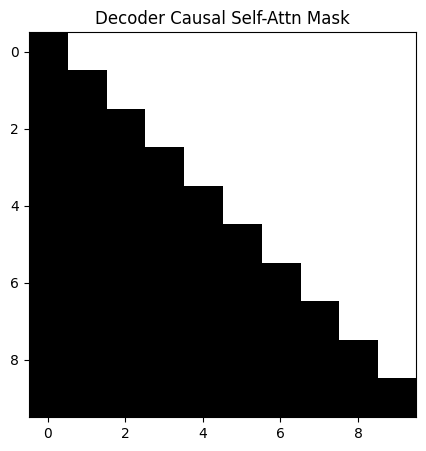

In [14]:
def create_mask(seq, pad_idx=None):
    """
    Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq (torch.Tensor): The input sequence tensor, shape (batch_size, sequence_length).
        pad_idx (int, optional): Padding token index. Defaults to None.

    Returns:
        torch.Tensor: A mask tensor with shape (batch_size, sequence_length, sequence_length).
    """
    sz_b, len_s = seq.size()
    device = seq.device  # Ensure the mask is on the same device as seq

    # Create an upper triangular matrix with zeros on the diagonal and below (allowed positions)
    # and ones above the diagonal (disallowed positions)
    subsequent_mask = torch.triu(torch.ones(len_s, len_s, device=device), diagonal=1).bool()

    # Expand the mask to match the batch size
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # Shape: (batch_size, len_s, len_s)

    if pad_idx is not None:
        len_q = seq.size(1)

        # Create a mask where padding positions in the key sequence are marked with True
        padding_mask = seq.eq(pad_idx)  # Shape: (batch_size, len_s)

        # Expand the padding mask to match the attention matrix dimensions
        padding_mask = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # Shape: (batch_size, len_q, len_s)

        # Combine the padding mask with the subsequent mask using logical OR
        mask = (padding_mask | mask)

    return mask



dec_causal_mask         = create_mask( torch.randn(4, 10)  , pad_idx=0)

# Black portions are attended to
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(dec_causal_mask[0], cmap="gray", aspect='auto')
axs.set_title("Decoder Causal Self-Attn Mask")


plt.show()


# Transformer Decoder Components

We will use these components in the Transformer decoder. These include positional encoding, feed-forward networks, scaled dot-product attention, and multi-head attention. Each of these components plays a vital role in processing input sequences and computing attention in the Transformer model.

---

## 1. **Positional Encoding (`PositionalEncoding`)**
Transformers do not inherently capture the order of sequences, so positional encodings are used to introduce sequence order into the model.

- **Purpose**: Adds information about the position of each token in the input sequence.
- **Mechanism**: Uses a combination of sine and cosine functions of different frequencies to generate positional encodings.
- **Parameters**:
  - `projection_size`: The size of the input embeddings (i.e., `d_model`).
  - `max_seq_len`: The maximum length of the input sequence (default: 1000).
- **Output**: The input embedding enriched with positional information, which is passed through a dropout layer for regularization.

---

In [15]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, projection_size, max_seq_len= 1000, dropout=0.1):
        super().__init__()
        self.dropout                = torch.nn.Dropout(dropout)

        pe              = torch.zeros(max_seq_len, projection_size)
        position        = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term        = torch.exp(torch.arange(0, projection_size, 2).float() * (-math.log(10000.0) / projection_size))
        pe[:, 0::2]     = torch.sin(position * div_term)
        pe[:, 1::2]     = torch.cos(position * div_term)
        pe              = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])




## 2. **Feed-Forward Network (`FeedForward`)**
The feed-forward network is a fully connected layer applied independently to each position in the sequence after the attention layers.

- **Purpose**: Projects the intermediate representations to a higher-dimensional space and back to the original model dimension.
- **Mechanism**: Consists of two linear layers with a GeLU activation function and dropout in between.
- **Parameters**:
  - `d_model`: The input and output dimensionality of the model.
  - `d_ff`: The dimensionality of the hidden layer in the feed-forward network (default: 2048).
  - `dropout`: Dropout rate applied after the GeLU activation (default: 0.1).
- **Output**: The transformed input sequence passed through two linear transformations with non-linear activation in between.

---

In [16]:

class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

        # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x



## 3. **Scaled Dot-Product Attention (`ScaledDotProductAttention`)**
This module computes the attention score for each query-key pair in the input sequence using the scaled dot-product mechanism.

- **Purpose**: To compute attention scores and generate weighted outputs based on the input query, key, and value matrices.
- **Mechanism**:
  - Calculates the dot product of queries and keys, scales by the square root of the dimension, and applies a softmax to generate attention weights.
  - Uses dropout for regularization.
- **Parameters**:
  - `temperature`: Scaling factor for the dot product.
  - `attn_dropout`: Dropout rate for attention weights (default: 0.1).
- **Output**: Returns the weighted sum of the values and the attention weights.

---


In [17]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=-1)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        # attn = torch.bmm(q, k.transpose(1, 2))
        attn = (q @ k.transpose(-2, -1))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            attn = attn.masked_fill(mask, float('-inf'))

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        # Compute the weighted sum of values based on the attention weights.
        # output  = torch.bmm(self.dropout(attn), v)
        attn = self.dropout(attn)
        output = attn @ v

        return output, attn # Return the attention output and the attention weights.

## 4. **Multi-Head Attention (`MultiHeadAttention`)**
This module implements multi-head attention, where multiple sets of attention heads are computed in parallel, and their outputs are concatenated.

- **Purpose**: To allow the model to jointly attend to different positions in the input sequence from different representation subspaces.
- **Mechanism**:
  - Projects the input query, key, and value matrices into multiple smaller subspaces (heads).
  - Computes scaled dot-product attention for each head in parallel.
  - Concatenates the outputs of all heads and applies a final linear transformation to project the result back to the original model dimension.
- **Parameters**:
  - `n_head`: Number of attention heads.
  - `d_model`: Dimensionality of the input and output representations.
  - `dropout`: Dropout rate applied to the attention output (default: 0.1).
- **Output**: Returns the concatenated output of all attention heads and the averaged attention weights.

---

In [18]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)
        torch.nn.init.normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)


        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
              # print(mask.shape)
              mask = mask.unsqueeze(1).repeat(1, n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output = output.transpose(1, 2).contiguous().view(sz_b, len_v, -1)

        output          = self.dropout(self.fc(output))

        attn_weights = attn.mean(dim=(0, 1))

        return output, attn_weights

# Transformer Decoder Layers

The `DecoderLayer1` and `DecoderLayer3` are modular components of the Transformer decoder. Each layer is designed to handle a specific function: self-attention, cross-attention, and feed-forward processing.

## 1. `DecoderLayer1`: Self-Attention Layer
- **Purpose**: Implements self-attention, where the decoder attends to its own inputs, combined with residual connections and layer normalization.
- **Components**:
  - `MultiHeadAttention`: Applies self-attention to the target sequence.
  - `LayerNorm`: Normalizes the output after the residual connection.
  - `Dropout`: Regularization to prevent overfitting.

## 3. `DecoderLayer3`: Feed-Forward Layer
- **Purpose**: Implements a feed-forward neural network for further transformation of the decoder's intermediate representations.
- **Components**:
  - `FeedForward`: A two-layer fully connected network with non-linearity.
  - `LayerNorm`: Applied after the residual connection.
  - `Dropout`: Regularization to avoid overfitting.


In [19]:
class DecoderLayer1(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        DecoderLayer (attention and layer norm) in the Transformer architecture.

        Args:
            d_model (int): The number of expected features in the input (embedding dimension).
            num_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feedforward network model.
            dropout (float): Dropout probability.
        """
        super(DecoderLayer1, self).__init__()

        # Self-Attention Layer
        self.self_attn = MultiHeadAttention(n_head=num_heads, d_model=d_model, dropout=dropout)

        # Layer Normalization
        self.layer_norm = nn.LayerNorm(d_model)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, attn_mask=None, key_padding_mask=None):
        # Apply layer norm to input
        tgt_norm = self.layer_norm(tgt)

        # Call self attention with mask
        attn_output, attn_weights = self.self_attn(tgt_norm, tgt_norm, tgt_norm, mask=attn_mask)

        # Apply dropout
        attn_output = self.dropout(attn_output)

        # Add skip connection
        tgt = tgt + attn_output

        return tgt, attn_weights



class DecoderLayer3(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Feedforward layer with layer normalization in the Transformer decoder.

        Args:
            d_model (int): Embedding dimension.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feedforward network.
            dropout (float): Dropout probability.
        """
        super(DecoderLayer3, self).__init__()

        # Feed-Forward Network
        self.ffn = FeedForward(d_model=d_model, d_ff=d_ff, dropout=dropout)

        # Layer Normalization
        self.layer_norm = nn.LayerNorm(d_model)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt):
        # Apply layer norm to input
        tgt_norm = self.layer_norm(tgt)

        # Call feed forward layer
        ffn_output = self.ffn(tgt_norm)

        # Apply dropout
        ffn_output = self.dropout(ffn_output)

        # Add skip connection
        tgt = tgt + ffn_output

        return tgt


# Causal Language Model

This module implements a Transformer-based decoder for causal language modeling (CLM). It consists of several components, including embedding layers, positional encoding, self-attention layers, and feed-forward layers. It supports various generation strategies such as beam search and sampling.

### Key Components:
- **Embedding Layer**: Converts input tokens into dense vector representations.
- **Positional Encoding**: Adds position information to input tokens, helping the model understand the order of tokens.
- **Decoder Layers**: Composed of:
  - `DecoderLayer1`: Implements self-attention and layer normalization.
  - `DecoderLayer3`: Implements a feed-forward network with residual connections.
- **Output Linear Layer**: Projects the hidden states to the vocabulary size to generate output probabilities.

### Key Methods:
- **`forward`**: Runs the input through the decoder layers and generates output probabilities.

In [20]:
class CausalLanguageModel(nn.Module):
    def __init__(self, vocab_size=31, d_model=256, num_layers=2, num_heads=2, d_ff=512, dropout=0.1, max_length=1000):

        """
        Decoder module in the Transformer architecture.
        Initializes embeddings, multiple decoder layers, and an output linear layer.

        Args:
            vocab_size (int): Size of the vocabulary.
            d_model (int): The number of expected features in the input (embedding dimension).
            num_layers (int): Number of decoder layers.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feedforward network model.
            dropout (float): Dropout probability.
            max_length (int): Maximum length of input sequences.
        """
        super(CausalLanguageModel, self).__init__()

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(projection_size=d_model, max_seq_len=max_length, dropout=dropout)

        self.num_layers = num_layers

        # Decoder Layers
        self.decoder_layers1 = nn.ModuleList([
            DecoderLayer1(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)
        ])

        self.decoder_layers3 = nn.ModuleList([
            DecoderLayer3(d_model=d_model, num_heads=num_heads, d_ff=d_ff, dropout=dropout) for _ in range(num_layers)
        ])

        # Final Layer Normalization
        self.layer_norm = nn.LayerNorm(d_model)

        # Fully Connected Output Layer
        self.fully_connected = nn.Linear(d_model, vocab_size)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, inp):
        # Generate the causal mask using the create_mask function
        attn_mask = create_mask(inp, pad_idx=PAD_TOKEN).to(inp.device)  # Ensure mask is on the same device as input

        # Convert input tokens to embeddings
        embedded = self.embedding(inp)  # Shape: (batch_size, seq_len, d_model)

        # Apply positional encoding
        embedded = self.pos_encoder(embedded)  # Shape: (batch_size, seq_len, d_model)

        attention_weights_list = []

        # Pass through each decoder layer
        for i in range(self.num_layers):
            # Apply DecoderLayer1 (Self-Attention)
            embedded, attn_weights = self.decoder_layers1[i](embedded, attn_mask=attn_mask)
            attention_weights_list.append(attn_weights)

            # Apply DecoderLayer3 (Feed-Forward)
            embedded = self.decoder_layers3[i](embedded)

        # Apply final layer normalization
        normalized = self.layer_norm(embedded)  # Shape: (batch_size, seq_len, d_model)

        # Apply the fully connected layer for classification
        output = self.fully_connected(normalized)  # Shape: (batch_size, seq_len, vocab_size)

        # Stack attention weights from all layers
        stacked_attention_weights = torch.stack(attention_weights_list, dim=0)  # Shape: (num_layers, batch_size, num_heads)

        return output, stacked_attention_weights

# Model, Loss, Optimizer, and Scheduler Definition

In [21]:
# TODO: Define the model
model = CausalLanguageModel(
    vocab_size = VOCAB_SIZE,
    d_model    = config["d_model"],
    num_layers = config["num_layers"],
    num_heads  = config["num_heads"],
    d_ff       = config["d_ff"],
    dropout    = config["dropout"],
    max_length = config["max_length"]
).to(DEVICE)

# TODO: Define the dataloader
train_loader = DataLoaderForLanguageModeling(
    dataset          = train_dataset,
    batch_size       = config["batch_size"],
    sequence_length  = config["max_length"],
    shuffle          = True,
    drop_last        = True
)

val_loader = DataLoaderForLanguageModeling(
    dataset          = val_dataset,
    batch_size       = config["batch_size"],
    sequence_length  = config["max_length"],
    shuffle          = False,
    drop_last        = False
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

total_steps = config["num_epochs"] * len(train_loader)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1000,
    num_training_steps=total_steps
)

scaler = torch.cuda.amp.GradScaler() if DEVICE == "cuda" else None

# print(model)

dummy_input = torch.randint(0, VOCAB_SIZE, (2, 5)).to(DEVICE)

summary = torchsummaryX.summary(model, dummy_input)

/tmp/ipykernel_23/2405960326.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if DEVICE == "cuda" else None


----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Embedding              [256, 1000]          [2, 5, 256]               256.00                 0.26
1_Dropout                          -          [2, 5, 256]                    -                    -
2_LayerNorm                    [256]          [2, 5, 256]                 0.51                 0.00
3_Linear                  [256, 256]          [2, 5, 256]                65.79                 0.07
4_Linear                  [256, 256]          [2, 5, 256]                65.79                 0.07
5_Linear                  [256, 256]          [2, 5, 256]                65.79                 0.07
6_Softmax                          -         [2, 4, 5, 5]                    -                    -
7_Dropout                          -         [2, 4, 5, 5]                    -                    -



# Trainer Class

In [22]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, scheduler, scaler, max_epochs=1):
        """
            Use this class to train your model
        """
        # Feel free to add any other parameters here
        self.model           = model
        self.train_loader    = train_loader
        self.val_loader      = val_loader
        self.optimizer       = optimizer
        self.criterion       = criterion
        self.scheduler       = scheduler
        self.scaler          = scaler

        self.train_losses           = []
        self.val_losses             = []
        self.prediction_probs       = []
        self.prediction_probs_test  = []
        self.generated_texts_test   = []
        self.generated_texts_test_beam = []
        self.generated_texts_test_beam_random = []
        self.generated_texts_validation = []

        self.log_likelihood_beam = []
        self.log_likelihood_beam_random = []

        self.epochs                 = 0
        self.max_epochs             = max_epochs


    def calculate_loss(self, out, target):
        # out: (batch_size, seq_len, vocab_size)
        # target: (batch_size, seq_len)
        out     = out.view(-1, out.size(-1))    # (B*T, V)
        targets = target.view(-1)              # (B*T)
        loss    = self.criterion(out, targets)
        return loss


    def train(self):
        self.model.train()  # Set model to training mode
        epoch_loss = 0
        attn_weights = None

        for batch_num, (inputs, targets) in enumerate(tqdm(self.train_loader, desc="Training")):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

            self.optimizer.zero_grad()

            if self.scaler:
                with torch.cuda.amp.autocast():
                    outputs, attn_weights = self.model(inputs)
                    loss = self.calculate_loss(outputs, targets)

                self.scaler.scale(loss).backward()
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                outputs, attn_weights = self.model(inputs)
                loss = self.calculate_loss(outputs, targets)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.optimizer.step()

            self.scheduler.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f' %
              (self.epochs, self.max_epochs, avg_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(avg_loss)

        return (avg_loss, self.optimizer.param_groups[0]['lr'], attn_weights)


    def validate(self):
        self.model.eval()  # Set model to evaluation mode
        epoch_loss = 0

        with torch.no_grad():
            for batch_num, (inputs, targets) in enumerate(tqdm(self.val_loader, desc="Validation")):
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)

                outputs, _ = self.model(inputs)
                loss = self.calculate_loss(outputs, targets)

                epoch_loss += loss.item()

        avg_loss = epoch_loss / (batch_num + 1)
        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f' %
              (self.epochs, self.max_epochs, avg_loss, self.optimizer.param_groups[0]['lr']))
        self.val_losses.append(avg_loss)

        return avg_loss

In [23]:
# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    train_loader = train_loader,
    val_loader  = val_loader,
    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,
    scaler      = scaler,
    max_epochs  = config["num_epochs"], # TODO: set the number of epochs
)

# Wandb

In [24]:
# Use wandb? Resume Training?
# USE_WANDB = True
# RESUME_LOGGING = False

# Create your wandb run

# run_name = None # TODO: pick a run name you like

# if USE_WANDB:
#
#     wandb.login(key=NotImplemented) # your wandb key
#
#     if RESUME_LOGGING:
#         run_id = ''
#         run = wandb.init(
#             settings=wandb.Settings(symlink=False),
#             id     = run_id, ### Insert specific run id here if you want to resume a previous run
#             resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
#             project = "hw4p1-f24", ### Project should be created in your wandb account
#         )
#     else:
#         run = wandb.init(
#             name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
#             reinit  = True, ### Allows reinitalizing runs when you re-run this cell
#             project = "hw4p1-f24", ### Project should be created in your wandb account
#             config  = config ### Wandb Config for your run
#         )
wandb.login(key="98642f33baa53793f08e5f32f1d09da8c7c6e80b")
run = wandb.init(
        reinit=True,
        project="HW4P1",
        config=config
    )

### Save your model architecture as a string with str(model)
model_arch  = str(model)
### Save it in a txt file
arch_file   = open("/kaggle/working/model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
# wandb.save('model_arch.txt')

wandb: WARNING Path /kaggle/input/hw4-p1/dataset/wandb/ wasn't writable, using system temp directory.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING Path /kaggle/input/hw4-p1/dataset/wandb/ wasn't writable, using system temp directory
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seitomoyi (seitomoyi-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /tmp/wandb/run-20241119_191547-44151l1j
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fan

# Experiments

In [25]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

wandb.watch(model, log="all")

# torch.cuda.empty_cache()
gc.collect()


for epoch in range(config['num_epochs']):
    train_loss, curr_lr,  attn_weights = trainer.train()
    print(attn_weights[-1].shape)

    test_loss = trainer.validate()

    wandb.log({"train_loss":train_loss,
               "test_loss": test_loss,
               "learning_rate": curr_lr
              })
    scheduler.step(test_loss)

### Finish your wandb run
run.finish()

torch.cuda.empty_cache()
gc.collect()

Training:   0%|          | 0/5254 [00:00<?, ?it/s]

/tmp/ipykernel_23/221916491.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[TRAIN] 	Epoch [1/50] 	Loss: 4.2625 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [1/50] 	Loss: 3.7111 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [2/50] 	Loss: 3.7218 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [2/50] 	Loss: 3.6014 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [3/50] 	Loss: 3.6398 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [3/50] 	Loss: 3.5482 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [4/50] 	Loss: 3.5933 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [4/50] 	Loss: 3.5115 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [5/50] 	Loss: 3.5626 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [5/50] 	Loss: 3.4838 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [6/50] 	Loss: 3.5392 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [6/50] 	Loss: 3.4681 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [7/50] 	Loss: 3.5211 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [7/50] 	Loss: 3.4482 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [8/50] 	Loss: 3.5061 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [8/50] 	Loss: 3.4379 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [9/50] 	Loss: 3.4940 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [9/50] 	Loss: 3.4269 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [10/50] 	Loss: 3.4840 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [10/50] 	Loss: 3.4170 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [11/50] 	Loss: 3.4748 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [11/50] 	Loss: 3.4105 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [12/50] 	Loss: 3.4669 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [12/50] 	Loss: 3.3993 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [13/50] 	Loss: 3.4601 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [13/50] 	Loss: 3.3979 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [14/50] 	Loss: 3.4538 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [14/50] 	Loss: 3.3934 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [15/50] 	Loss: 3.4481 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [15/50] 	Loss: 3.3870 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [16/50] 	Loss: 3.4427 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [16/50] 	Loss: 3.3792 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [17/50] 	Loss: 3.4383 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [17/50] 	Loss: 3.3784 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [18/50] 	Loss: 3.4340 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [18/50] 	Loss: 3.3715 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [19/50] 	Loss: 3.4299 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [19/50] 	Loss: 3.3674 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [20/50] 	Loss: 3.4265 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [20/50] 	Loss: 3.3654 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [21/50] 	Loss: 3.4231 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [21/50] 	Loss: 3.3596 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [22/50] 	Loss: 3.4198 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [22/50] 	Loss: 3.3588 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [23/50] 	Loss: 3.4171 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [23/50] 	Loss: 3.3559 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [24/50] 	Loss: 3.4146 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [24/50] 	Loss: 3.3544 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [25/50] 	Loss: 3.4119 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [25/50] 	Loss: 3.3516 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [26/50] 	Loss: 3.4095 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [26/50] 	Loss: 3.3503 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [27/50] 	Loss: 3.4071 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [27/50] 	Loss: 3.3489 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [28/50] 	Loss: 3.4053 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [28/50] 	Loss: 3.3459 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [29/50] 	Loss: 3.4033 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [29/50] 	Loss: 3.3446 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [30/50] 	Loss: 3.4017 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [30/50] 	Loss: 3.3426 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [31/50] 	Loss: 3.3996 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [31/50] 	Loss: 3.3386 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [32/50] 	Loss: 3.3978 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [32/50] 	Loss: 3.3395 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [33/50] 	Loss: 3.3961 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [33/50] 	Loss: 3.3353 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [34/50] 	Loss: 3.3946 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [34/50] 	Loss: 3.3374 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [35/50] 	Loss: 3.3932 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [35/50] 	Loss: 3.3319 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [36/50] 	Loss: 3.3918 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [36/50] 	Loss: 3.3341 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [37/50] 	Loss: 3.3907 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [37/50] 	Loss: 3.3309 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [38/50] 	Loss: 3.3893 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [38/50] 	Loss: 3.3282 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [39/50] 	Loss: 3.3883 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [39/50] 	Loss: 3.3261 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [40/50] 	Loss: 3.3872 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [40/50] 	Loss: 3.3233 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [41/50] 	Loss: 3.3857 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [41/50] 	Loss: 3.3249 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [42/50] 	Loss: 3.3843 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [42/50] 	Loss: 3.3260 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [43/50] 	Loss: 3.3835 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [43/50] 	Loss: 3.3235 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [44/50] 	Loss: 3.3822 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [44/50] 	Loss: 3.3240 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [45/50] 	Loss: 3.3814 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [45/50] 	Loss: 3.3190 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [46/50] 	Loss: 3.3802 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [46/50] 	Loss: 3.3208 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [47/50] 	Loss: 3.3797 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [47/50] 	Loss: 3.3214 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [48/50] 	Loss: 3.3787 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [48/50] 	Loss: 3.3192 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [49/50] 	Loss: 3.3775 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [49/50] 	Loss: 3.3164 	Lr: 0.000984


Training:   0%|          | 0/5254 [00:00<?, ?it/s]

[TRAIN] 	Epoch [50/50] 	Loss: 3.3769 	Lr: 0.000984
torch.Size([50, 50])


Validation:   0%|          | 0/27 [00:00<?, ?it/s]

[VAL] 	Epoch [50/50] 	Loss: 3.3163 	Lr: 0.000984


wandb:                                                                                
wandb: 
wandb: Run history:
wandb: learning_rate █▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb:     test_loss █▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: learning_rate 0.00098
wandb:     test_loss 3.31627
wandb:    train_loss 3.37693
wandb: 
wandb: 🚀 View run fancy-pine-9 at: https://wandb.ai/seitomoyi-carnegie-mellon-university/HW4P1/runs/44151l1j
wandb: ⭐️ View project at: https://wandb.ai/seitomoyi-carnegie-mellon-university/HW4P1
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: /tmp/wandb/run-20241119_191547-44151l1j/logs


765

# Testing Your Model's Perplexity

In [26]:
def log_softmax(x, axis):
    ret = x - np.max(x, axis=axis, keepdims=True)
    lsm = np.log(np.sum(np.exp(ret), axis=axis, keepdims=True))
    return ret - lsm

def get_prediction_nll_single_for_test(out, targ):
    out = log_softmax(out, 1)
    nlls = out[np.arange(out.shape[0]), targ]
    nll = -np.sum(nlls)
    return nll

In [27]:
test_df = pd.read_csv("/kaggle/input/hw4-p1/dataset/test-clean/transcripts.csv")
test_transcripts  = []
test_transcripts = [np.array([i for i in row['transcripts'].replace("<sos>", "").replace("<eos>", "") ]) for index, row in test_df.iterrows()]

test_dataset = []
for files in test_transcripts:
    tokenized = "".join(files)
    tokenized = TOKENIZER.encode(tokenized)
    test_dataset.append(tokenized)

In [28]:
test_dl = DataLoaderForLanguageModeling(
    dataset         = test_dataset,
    batch_size      = 1,
    shuffle         = False,
    drop_last       = False,
    sequence_length = config["max_length"]
)

nnls = []
model.eval()

for batch_num, (inputs, targets) in enumerate(tqdm(test_dl)):
    inputs = inputs.long().to(DEVICE)
    targets = targets.long().to(DEVICE)

    with torch.no_grad():
        output = model(inputs)
    nnl = get_prediction_nll_single_for_test(output[0][0].to('cpu').numpy(), targets[0].to('cpu').numpy())
    if TOKENIZER != None:
        text_len = len(TOKENIZER.decode(targets.flatten().to('cpu')).replace("<|endoftext|>", "")) + 1
    else:
        text_len = len(targets[0])
    nnls.append(nnl / text_len)

test_ppl = np.exp(sum(nnls) / len(nnls))
print(f'test_perplexity: {test_ppl}')
with open('/kaggle/working/test_perplexity.txt', 'w') as f:
    f.write(str(test_ppl))

  0%|          | 0/201 [00:00<?, ?it/s]

test_perplexity: 3.1614042204863027
